# Data access

This tutorial demonstrates how to use the JetNet library to load, access, inspect, and prepare the JetNet dataset for machine learning.

## Data loading

We'll use the `jetnet.datasets.JetNet.getData` function to download and directly access the dataset.

First, we can check which particle and jet features are available in this dataset:

In [1]:
from jetnet.datasets import JetNet
print(f"Particle features: {JetNet.all_particle_features}")
print(f"Jet features: {JetNet.all_jet_features}")

Particle features: ['etarel', 'phirel', 'ptrel', 'mask']
Jet features: ['type', 'pt', 'eta', 'mass', 'num_particles']


Next, let's load the data:

In [2]:
from jetnet.datasets import JetNet

data_args = {
    "jet_type": ["g", "q"],  # gluon and quark jets
    "data_dir": "../datasets/jetnet",
    # choosing only the kinematic features here
    "particle_features": ["etarel", "phirel", "ptrel"],
    "num_particles": 30,
    "jet_features": ["type", "pt", "eta", "mass"],
}

particle_data, jet_data = JetNet.getData(**data_args)

Let's look at some of the data:

In [3]:
print(f"Particle features of the 10 highest pT particles in the first jet\n{data_args['particle_features']}\n{particle_data[0, :10]}")
print(f"\nJet features of first jet\n{data_args['jet_features']}\n{jet_data[0]}")

Particle features of the 10 highest pT particles in the first jet
['etarel', 'phirel', 'ptrel']
[[-0.00119465 -0.00868234  0.07526182]
 [ 0.040659   -0.01917223  0.04220497]
 [ 0.00320636  0.00189248  0.03439658]
 [-0.02547882  0.02908633  0.03265509]
 [ 0.04065903 -0.02917723  0.02732484]
 [-0.01184096 -0.06169375  0.02635964]
 [-0.00934097  0.06086848  0.02526115]
 [ 0.01342733 -0.06498301  0.02508761]
 [ 0.04017338 -0.02480143  0.02462937]
 [-0.03034277  0.03402254  0.02324519]]

Jet features of first jet
['type', 'pt', 'eta', 'mass']
[0.00000000e+00 1.16691333e+03 4.74340975e-01 9.28546982e+01]


We can also visualise these jets as images:

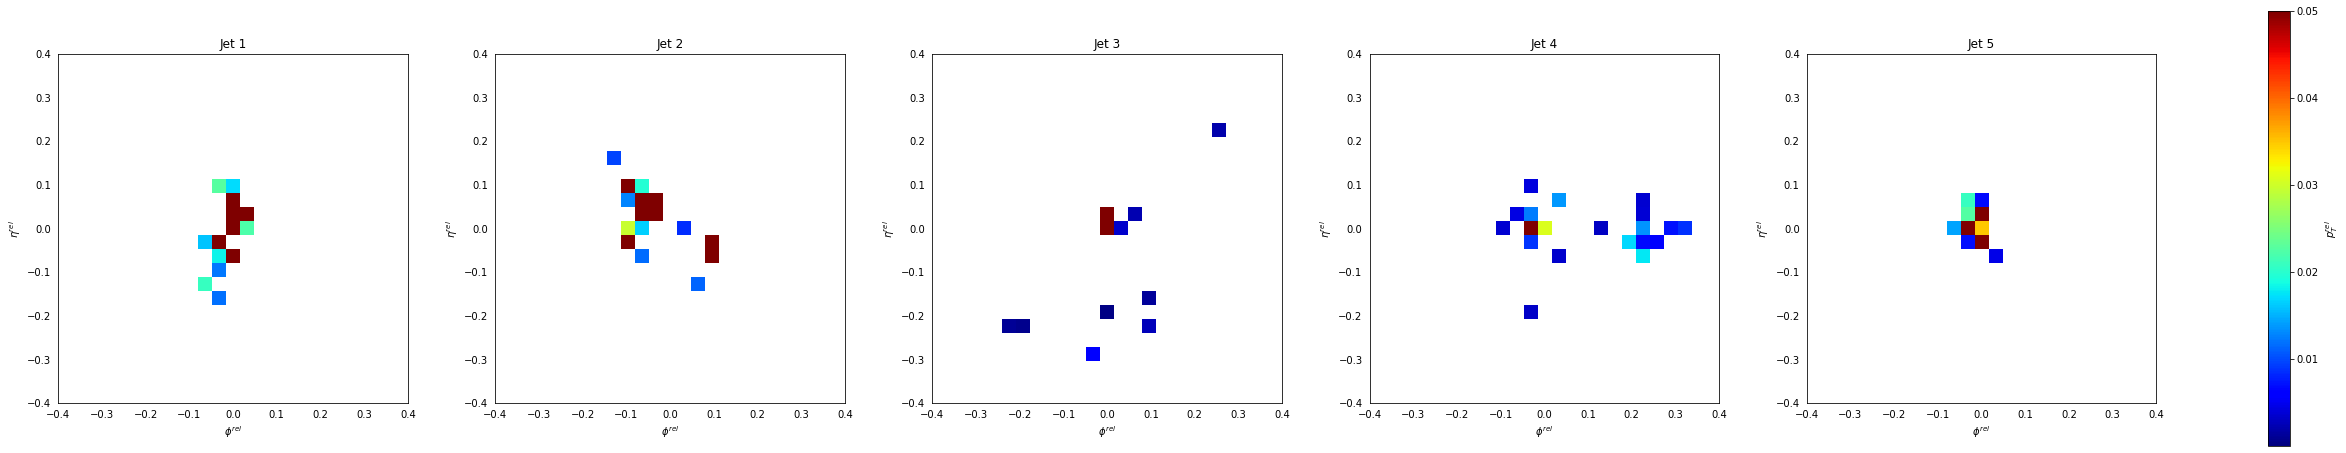

In [4]:
from jetnet.utils import to_image
import matplotlib.pyplot as plt

num_images = 5
im_size = 25  # number of pixels in height and width
maxR = 0.4  # max radius in (eta, phi) away from the jet axis

cm = plt.cm.jet.copy()
cm.set_under(color="white")
plt.rcParams.update({"font.size": 16})

fig, axes = plt.subplots(
    nrows=1,
    ncols=num_images,
    figsize=(40, 8),
    gridspec_kw={"wspace": 0.25},
)

for i in range(num_images):
    im = axes[i].imshow(
        to_image(particle_data[i], im_size, maxR=maxR),
        cmap=cm,
        interpolation="nearest",
        vmin=1e-8,
        extent=[-maxR, maxR, -maxR, maxR],
        vmax=0.05,
    )
    axes[i].tick_params(which="both", bottom=False, top=False, left=False, right=False)
    axes[i].set_xlabel("$\phi^{rel}$")
    axes[i].set_ylabel("$\eta^{rel}$")
    axes[i].set_title(f"Jet {i + 1}")

cbar = fig.colorbar(im, ax=axes.ravel().tolist(), fraction=0.01)
cbar.set_label("$p_T^{rel}$")


## Dataset preparation

To prepare the dataset for machine learning applications, we can use the `jetnet.datasets.JetNet` class itself, which inherits the `pytorch.data.utils.Dataset` class.

We'll also use the class to normalise the features to have zero means and unit standard deviations, and transform the jet type feature to be one-hot-encoded.

In [5]:
from jetnet.datasets import JetNet
from jetnet.datasets.normalisations import FeaturewiseLinear

import numpy as np
from sklearn.preprocessing import OneHotEncoder


# function to one hot encode the jet type and leave the rest of the features as is
def OneHotEncodeType(x: np.ndarray):
    enc = OneHotEncoder(categories=[[0, 1]])
    type_encoded = enc.fit_transform(x[..., 0].reshape(-1, 1)).toarray()
    other_features = x[..., 1:].reshape(-1, 3)
    return np.concatenate((type_encoded, other_features), axis=-1).reshape(*x.shape[:-1], -1)


data_args = {
    "jet_type": ["g", "q"],  # gluon and quark jets
    "data_dir": "../datasets/jetnet",
    # these are the default particle features, written here to be explicit
    "particle_features": ["etarel", "phirel", "ptrel", "mask"],
    "num_particles": 10,  # we retain only the 10 highest pT particles for this demo
    "jet_features": ["type", "pt", "eta", "mass"],
    # we don't want to normalise the 'mask' feature so we set that to False
    "particle_normalisation": FeaturewiseLinear(normal=True, normalise_features=[True, True, True, False]),  
    # we also don't want to normalise the jet 'type' feature
    "jet_normalisation": FeaturewiseLinear(
        normal=True, normalise_features=[False, True, True, True]
    ),
    # pass our function as a transform to be applied to the jet features
    "jet_transform": OneHotEncodeType,
}

jets_train = JetNet(**data_args, split="train")
jets_valid = JetNet(**data_args, split="valid")


We can look at one of our datasets to confirm everything is as we expect:

In [6]:
jets_train

Dataset JetNet
    Number of datapoints: 243551
    Data location: ../datasets/jetnet
    Including ['g', 'q'] jets
    Split into train data out of ['train', 'valid', 'test', 'all'] possible splits, with splitting fractions [0.7, 0.15, 0.15]
    Particle features: ['etarel', 'phirel', 'ptrel', 'mask'], max 10 particles per jet
    Jet features: ['type', 'pt', 'eta', 'mass']
    Particle normalisation: Normalising features to zero mean and unit standard deviation, normalising features: [True, True, True, False]
    Jet normalisation: Normalising features to zero mean and unit standard deviation, normalising features: [False, True, True, True]
    Jet transform: <function OneHotEncodeType at 0x162233010>

And also directly at the data itself - note that the features have been normalised and the jet type has been one-hot-encoded):

In [7]:
particle_features, jet_features = jets_train[0]
print(f"Particle features ({data_args['particle_features']}):\n\t{particle_features}")
print(f"\nJet features ({data_args['jet_features']}):\n\t{jet_features}")

Particle features (['etarel', 'phirel', 'ptrel', 'mask']):
	tensor([[-0.0244, -0.1820,  0.0086,  1.0000],
        [ 0.8411, -0.4009, -0.3981,  1.0000],
        [ 0.0666,  0.0387, -0.4941,  1.0000],
        [-0.5266,  0.6064, -0.5155,  1.0000],
        [ 0.8411, -0.6098, -0.5811,  1.0000],
        [-0.2446, -1.2885, -0.5930,  1.0000],
        [-0.1929,  1.2697, -0.6065,  1.0000],
        [ 0.2779, -1.3571, -0.6086,  1.0000],
        [ 0.8310, -0.5184, -0.6143,  1.0000],
        [-0.6272,  0.7094, -0.6313,  1.0000]])

Jet features (['type', 'pt', 'eta', 'mass']):
	tensor([1.0000, 0.0000, 0.5454, 0.6020, 0.3307])


We can now feed this into a PyTorch DataLoader and start training!

Next things you can try are:
 - Repeat this with the Top Quark Tagging dataset (`jetnet.datasets.TopTagging`)
 - Training an ML model (tutorial #2)